**Percent of gap explained by decaying 16S rRNA**

This Jupyter notebook illustrates how we simulate production and decay of 16S rRNA of dead bacteria using the LD model.

The notebook runs in Jupyter, but the codes could be pasted together into a larger Python 3 script, if you want to run outsize of Jupyter.

We used python3.11, but other recent python3 versions will probably work just fine.

The code requires installing the following python3 packages:
* IPython
* numpy
* scipy
* pandas
* matplotlib

In [2]:
#########################################################################
##                                                                     ##
##   This python script fits LD model to in vitro CFU and 16S rRNA     ##
##   counts of Mtb from cultures treated with HRZE.                    ##
##   After fitting (and displaying results), the program simulates LD  ##
##   model with various decay rates deltaS and                         ##
##   calculates the predicted logarithmic gap. The percent gap is      ##
##   then reported at different times, calculated                      ##
##   as the 100% x gap(model)/gap(observed)                            ##
##   Some other simulations are also included, which were used to      ##
##   generate the cartoon illustrating model and observed gaps         ##
##   (panel c of figure 2).                                            ##
##                                                                     ##
##   While we have broken this into a series of cells, later cells     ##
##   require running some of the earlier cells. For example, the       ##
##   cell that calculates model fits must run before any of the cells  ##
##   that generate figure panels. However, it is possible to run the   ##
##   code for any figure panel without previously generating the       ##
##   other figure panels.                                              ##
##                                                                     ##
##                                                                     ##
##   Author: Allan Friesen, Texas Biomedical Research Institute        ##
##   Date: 16 July 2025                                                ##
##   Revised: 11 Nov 2025                                              ##
##                                                                     ##
#########################################################################


#Import needed packages

from IPython.display import Image, display
import PIL.Image
from math import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from operator import sub

In [3]:
#This cell reads in vitro data file, extracts days of treatment, CFU, and 16S rRNA counts,
#then generates relevant averages.

def meanByLog( data, replace = False, rep0 = -1., defaultValue = -1. ):
    #Returns the geometric mean
    #data = data to be averaged
    #rep0 = value to use for logarithm when a data point is non-positive (requires replace = True).
    #replace = logical that determines whether to ignore non-positive values (False) or to replace them (True)
    #defaultValue = value to return if no usable points are found (in practice, this replaces zero)
    ave = 0.
    n = 0.
    for d in data:
        if( d > 0 ):
            ave = ave + log(d)
            n = n + 1.
        else:
            if(replace):
                ave = ave + rep0
                n = n + 1.
    if( n == 0. ):
        ave = defaultValue
    else:
        ave = ave / n
    return exp(ave)

volume16s = 0.050 #Volume of qPCR sample in mL (50 microliters)
sCFU='CFU' #label for CFU in dataframe
s16S='Adjusted.16S.Original' #label for 16S rRNA counts in dataframe
sDays='Treatment.days' #label for days since treatment start in dataframe


#read data from file
df = pd.read_excel('gapData.xlsx',sheet_name='inVitro').sort_values(by=sDays)
#extract days
days = df[sDays].values
#extract list of unique days
daysunique = df[sDays].unique()
#extract CFU
cfus = df[sCFU ].values
#calculate averages
cfusav =[]
for t in daysunique:
    cfusav.append( meanByLog( df.loc[df[sDays]==t][sCFU].values ) ) #geometric mean CFU for each time point
r16s = df[s16S].values
for i in range( len( r16s ) ):
    r16s[i] = r16s[i] / volume16s #rescale 16S rRNA counts to be per mL, to match CFU data, which is also for 1 mL
r16sav = []
for t in daysunique:
    r16sav.append( meanByLog( df.loc[df[sDays]==t][s16S].values ) ) #average 16S rRNA counts, calculated as geometric mean

#numpy arrays
cfusav = np.array( cfusav )
r16sav = np.array( r16sav )
#mean logs
lncfusav = np.log( cfusav )
lnr16sav = np.log( r16sav )

#observed gap
gapData = r16sav / cfusav # 16S rRNA counts / CFU. Change in log of this ratio produces the logarithmic gap.
gapData = gapData/gapData[0] #proportionate gap
logGapData = np.log10( gapData )  #logarithmic gap


In [4]:
#This cell fits LD model to observed CFU and 16S rRNA counts

def dd( t, bd, rateM ): #The function name "dd" is a holdover from some former work, where our model was called "dependent dynamics model".
                        #This function does nothing but multiply the rate matrix by the population vector.
                        #Creating this function allows use of the solve_idp function
    return rateM.dot(bd)#The population vector is called "bd" because it contains platable bacteria (b) and dead (d)

def ddDynamics(deltaB,deltaB2,deltaS,b10,b20,d0,startTime,endTime,nt=-1):
    if(nt<0):
        nt = endTime - startTime + 1
    rateMatrix = np.array([[-deltaB,0,0],[0,-deltaB2,0],[deltaB,deltaB2,-deltaS]])
    initialValues = np.array([b10,b20,d0])
    tRange = [startTime,endTime]
    integrateModel = solve_ivp(dd,tRange,initialValues,args=(rateMatrix,),t_eval=np.linspace(startTime,endTime,nt),method='LSODA')
    return integrateModel

def resLog10( data, model, threshold = 0., replaceZero = 0.1 ):
    #returns sum of squared residuals between two 1D arrays
    res = 0.
    for i in range( data.size ):
        if( data[i] > threshold ):
            if( data[i] > 0. ):
                dif = log10(data[i]/model[i])
            else:
                dif = log10(replaceZero/model[i])
            res = res + dif * dif
    return res

def residual( params, b0, s0, cfu, rna, days ):
    #returns sum of squared residuals between simulation results and observed CFU and 16S rRNA counts
    #get parameters from array
    deltaB1 = params[0]
    deltaB2 = params[1]
    deltaS = params[2]
    log10x2 = params[3]
    #calculate n0, assuming D0 = 0 (so that copy number is just 16S rRNA counts / CFU)
    n0 = s0/b0
    #antilog to get initial value of x2 (slower-dying population fraction)
    x20 = pow(10,log10x2)
    #initial value of x1 (faster-dying population fraction)
    x10 = 1 - x20
    #initial populations
    b10 = x10 * b0
    b20 = x20 * b0
    #initialize residual to 0
    resid = 0.
    #simulate the dynamics with the current parameters
    fitdata = ddDynamics(deltaB1,deltaB2,deltaS,b10,b20,0,0,56,nt=56+1)
    #empty lists to hold relevant simulation results
    cfufit = []
    rnafit = []
    #extract simulation results
    b1 = fitdata["y"][0]
    b2 = fitdata["y"][1]
    d = fitdata["y"][2]
    #get CFU and 16S rRNA counts from raw simulation results
    b = b1 + b2
    s = (b + d) * n0
    #build arrays of predicted CFU and 16S rRNA counts for comparison with observed data
    for t in days:
        cfufit.append( b[t] )
        rnafit.append( s[t] )
    #numpy arrays
    cfufit = np.array( cfufit )
    rnafit = np.array( rnafit )
    #add residual for CFU
    resid = resid + resLog10( cfu, cfufit )
    #add residual for 16S rRNA
    resid = resid + resLog10( rna, rnafit )
    return resid

#initial populations
b0sim = cfusav[0]
s0sim = r16sav[0]

#initial parameter values
delta1 = 1.25
delta2 = 0.3
deltaS=.25
log10x2 = -3.7

####################FITTING LD MODEL TO DATA
params = [delta1,delta2,deltaS,log10x2]
bounds = ((1.2,1.4),(0.2,0.4),(0.2,0.35),(-4,-3))
print( "bounds: ", bounds )
modelFit = minimize( residual, params, args=(b0sim, s0sim, cfus, r16s, days), bounds = bounds, method = 'Nelder-Mead' )
print(modelFit)
#extract parameters
fitParams = modelFit["x"]
delta1  = fitParams[0]
delta2  = fitParams[1]
deltaS  = fitParams[2]
log10x2 = fitParams[3]
x2 = pow(10,log10x2)
x1 = 1 - x2
b10 = x1 * b0sim
b20 = x2 * b0sim

#print results of fitting
print( "Results of minimization:" )
print( "deltaB1 =  ", delta1, "/day", r"  t1/2 =  ", log(2)/delta1,  " days" )
print( "deltaB2 =  ", delta2, "/day", r"  t1/2 =  ", log(2)/delta2,  " days" )
print( "deltaS = ", deltaS, "/day", "  t1/2 =  ", log(2)/deltaS, " days" )
print( "log10x2", log10x2, "x2 = ", pow(10, log10x2) )
print( "Fixed parameters:" )
print( "B(0) = ", b0sim )
print( "S(0) = ", s0sim )
print( "B1(0) = ", b10 )
print( "B2(0) = ", b20 )
print( "n0   = ", s0sim/b0sim, " = ", s0sim/(b10 + b20) ) #this should output the same value twice (consistency check)


bounds:  ((1.2, 1.4), (0.2, 0.4), (0.2, 0.35), (-4, -3))
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11.285006828887761
             x: [ 1.307e+00  2.774e-01  2.606e-01 -3.587e+00]
           nit: 85
          nfev: 173
 final_simplex: (array([[ 1.307e+00,  2.774e-01,  2.606e-01, -3.587e+00],
                       [ 1.307e+00,  2.774e-01,  2.606e-01, -3.587e+00],
                       ...,
                       [ 1.307e+00,  2.774e-01,  2.606e-01, -3.587e+00],
                       [ 1.307e+00,  2.774e-01,  2.606e-01, -3.587e+00]]), array([ 1.129e+01,  1.129e+01,  1.129e+01,  1.129e+01,
                        1.129e+01]))
Results of minimization:
deltaB1 =   1.3065756587385091 /day   t1/2 =   0.5305067302640359  days
deltaB2 =   0.277364916547049 /day   t1/2 =   2.499044180457364  days
deltaS =  0.2605951566645778 /day   t1/2 =   2.659862099632658  days
log10x2 -3.586709854406476 x2 =  0.0002589942638904271
Fixed pa

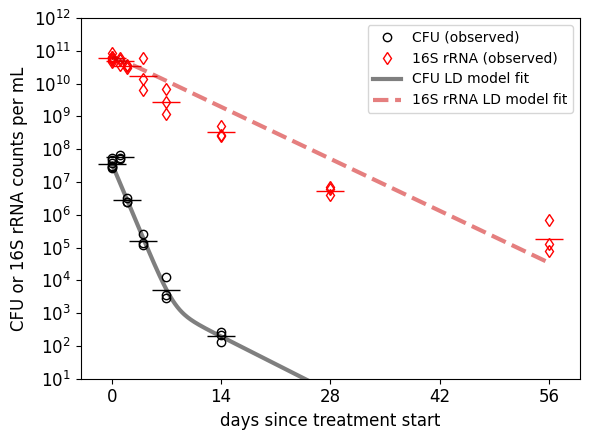

In [5]:
#This cell plots the model best fit along with the experimental data
#If you have previously run the code for making a different figure panel, be sure to rerun the 
#code that fits the LD model to the experimental data, before running this code (otherwise, you 
#may inherit wrong model parameters from the other simulations).
#Now, simulate the dynamics using the resulting parameters (requires running previous cell first)
modelPredictions = ddDynamics( delta1, delta2, deltaS, b10, b20, 0, 0, 56, nt=10*56+1 )

#collect simulation results
n0 = r16sav[0]/b0sim
tsim = modelPredictions["t"]
bsim1 = modelPredictions["y"][0]
bsim2 = modelPredictions["y"][1]
dsim = modelPredictions["y"][2]
bsim = bsim1 + bsim2
ssim = n0 * (bsim + dsim)

#Plot data and model fit
#parameters for manipulating line color
darkness = 0.2
lightness = 1 - darkness
transparency = 0.5
darkpink = (1*lightness,0,0)
#font size for labels in the figure
fontsize=12
fig,ax = plt.subplots(figsize=(6,4.5))
#plot data
ax.plot(days,cfus,linestyle='none',marker='o',markerfacecolor='none',color = 'black',label="CFU (observed)")
ax.plot(days,r16s,linestyle='none',marker='d',markerfacecolor='none',color = 'red',label="16S rRNA (observed)")
#plot averages
ax.plot(daysunique,cfusav,linestyle='none',marker='_',markerfacecolor='none',color='black',markersize=20)
ax.plot(daysunique,r16sav,linestyle='none',marker='_',markerfacecolor='none',color='red',markersize=20)
#plot model fit
ax.plot(tsim,bsim,color='black',alpha=1-transparency,linewidth=3,label="CFU LD model fit")
ax.plot(tsim,ssim,color=darkpink,alpha=1-transparency,linewidth=3,linestyle='dashed',label="16S rRNA LD model fit")
#logscale
ax.set_yscale('log')
#axis labels
ax.set_xlabel('days since treatment start',fontsize=fontsize)
ax.set_ylabel('CFU or 16S rRNA counts per mL',fontsize=fontsize)
#tick marks
ax.set_xticks([0,14,28,42,56])
ax.set_yticks([pow(10,1),pow(10,2),pow(10,3),pow(10,4),pow(10,5),pow(10,6),pow(10,7),pow(10,8),pow(10,9),pow(10,10),pow(10,11),pow(10,12)])
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
#plot window
ax.set_xlim(-4,60)
ax.set_ylim(pow(10,1),pow(10,12))
#include legend
plt.legend(ncols=1)
#adjust layout
plt.tight_layout()
#save the figure
plt.savefig('inVitroPanelA.pdf',format='pdf')


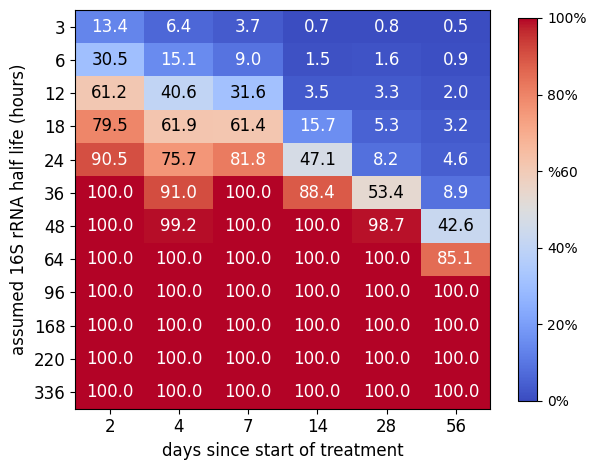

In [6]:
#This cell runs simulations with different assumed decay rates of 16S rRNA from dead bacteria.
#You must first run the cell that fits the LD model to observed 16S rRNA counts and CFU, in order 
#to get the other model parameters.
#This cell also generates a heatmap of the resulting percent of observed gap explained by the model

ppd  = 10 #points per day
def index( t ):
    #returns the index in simulation results of populations at time t
    return t * ppd


#List of half lifes for simulations
halfLifeList = np.array([3,6,12,18,24,36,48,64,96,168,220,336]) #in hours
halfLifeListDays = halfLifeList/24 #list of half lifes to simulate, in days
for i in range( halfLifeListDays.size ):
    if (halfLifeListDays[i] == 0):
        halfLifeListDays[i] = 0.001 #short half life limit - not used in paper - the predicted gap will be zero.
deltaSlist = np.log(2)/halfLifeListDays #list of decay rates to simulate
ppd = 10 #points per day - simulation parameter that primarily matters for visualization
#initialize list to hold results
tableGapLog = []
for deltaS in deltaSlist:
    #integrate model
    modelPredictions = ddDynamics( delta1, delta2, deltaS, b10, b20, 0, 0, 56, nt=ppd*56+1 )
    #collect simulation results
    n0 = r16sav[0]/b0sim
    tsim = modelPredictions["t"]
    bsim1 = modelPredictions["y"][0]
    bsim2 = modelPredictions["y"][1]
    dsim = modelPredictions["y"][2]
    bsim = bsim1 + bsim2
    ssim = n0 * (bsim + dsim)
    #calculate gap
    modelGap = ssim/bsim #proportionate gap
    modelGap = modelGap / modelGap[0] #proportionate gap starts at 1.
    modelGapLog = np.log10( modelGap ) #logarithmic gap (starts at 0)
    deltaSgapLog = [] #array to hold the portion of the (logarithmic) gap explainable by decay at rate deltaS
    #calculate fraction of gap explained by the model
    for d in range( len( daysunique ) ):
        if( d > 1 ):
            if (cfusav[d] < 0.5):
                #When CFU are not detected, the observed gap is not well defined. Accordingly, substitute 
                #The model predicted CFU (i.e., bsim[index(daysunique[d])]).
                logGapData[d] = log10((r16sav[d]/bsim[index(daysunique[d])])/(r16sav[0]/cfusav[0]))
            if (logGapData[d] == 0):
                #When the gap is zero, the fraction of the gap is not well defined. This is only relevant at time 
                #of treatment start, which we omit from our final analysis.
                deltaSgapLog.append( 100 )
            else:
                #If observed gap is not zero, simply calculate the percent of the 
                #gap explained as 100% x model gap/observed gap
                deltaSgapLog.append( 100 * modelGapLog[index(daysunique[d])]/logGapData[d] )
    tableGapLog.append( deltaSgapLog )

#Cap values at 100% (You can optionally comment this loop, if interested 
#in the extent to which the model gap exceeds 100% of the observed gap.)
for i in range( len(tableGapLog) ):
    for j in range( len(tableGapLog[0]) ):
        if (tableGapLog[i][j] > 100):
            tableGapLog[i][j] = 100

#shrink factor for the figure
shrink = 0.96
#fontsize for the figure
fontsize=12
fig,ax=plt.subplots()
#set up axes
ax.set_xticks( np.arange(len(daysunique) - 2 ), daysunique[2:], fontsize=fontsize )
ax.set_yticks( np.arange(len(halfLifeList)), halfLifeList, fontsize=fontsize )
#generate heatmap
heatmap = ax.imshow(tableGapLog,aspect=0.48,cmap='coolwarm', vmin=0, vmax = 100)
#add labels
for i in range( len(halfLifeList) ):
    for j in range( len( daysunique ) - 2 ):
        #number to write in the grid
        number = tableGapLog[i][j]
        #switch font color between dark and light cells, for readability
        if (abs(number-50) < 30):
            color = "black"
        else:
            color = "w"
        #add the label
        ax.text(j, i, f"{number:.1f}", ha="center", va="center", color=color, fontsize=fontsize)
#label axes
ax.set_ylabel( "assumed 16S rRNA half life (hours)", fontsize=fontsize )
ax.set_xlabel( "days since start of treatment", fontsize=fontsize )
#add colorbar
cbar=plt.colorbar(heatmap, shrink = shrink,ticks=[0,20,40,60,80,100])
#label colorbar
cbar.ax.set_yticklabels(["0%","20%","40%","%60","80%","100%"])
#adjust layout
plt.tight_layout()
#save figure
plt.savefig('inVitroPanelD.pdf',format='pdf')


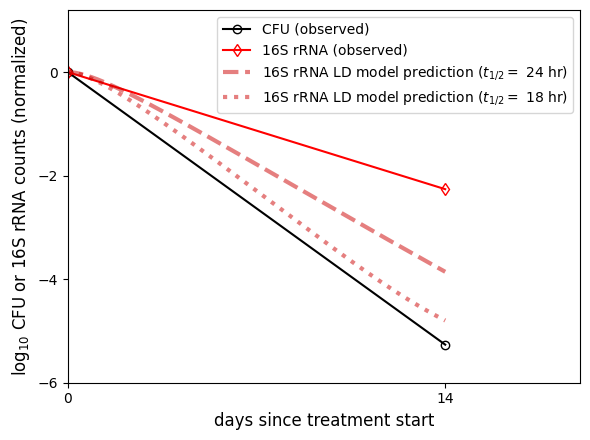

In [7]:
#This cell generates the graph for illustrating how the model and observed gaps are defined with normalized data

#normalized mean CFU and 16S rRNA counts.
meanCFUnorm = cfusav / cfusav[0]
mean16Snorm = r16sav / r16sav[0]

#values to plot (day 0 and day 14)
bPlotData    = np.array([meanCFUnorm[0],meanCFUnorm[5]])
sPlotData    = np.array([mean16Snorm[0],mean16Snorm[5]])
#corresponding days (time axis)
daysPlotData = [daysunique[0],daysunique[5]]
#mean death rate between day 0 and day 14 of treatment
delta = log(bPlotData[0]/bPlotData[1])/(daysPlotData[1] - daysPlotData[0])
#assumed 16S rRNA decay rate
deltaS = log(2)/1.

#model predictions
modelPredictionsC = ddDynamics( delta1, delta2, deltaS, x1, x2, 0, 0, 14, nt=10*14+1 )

#collect trajectories from simulation
n0 = 1
tsimC = modelPredictionsC["t"]
bsimC1 = modelPredictionsC["y"][0]
bsimC2 = modelPredictionsC["y"][1]
dsimC = modelPredictionsC["y"][2]
bsimC = bsimC1 + bsimC2
ssimC = bsimC + dsimC

#logscale data
bsimC = np.log10(bsimC)
ssimC = np.log10(ssimC)
bPlotData = np.log10(bPlotData)
sPlotData = np.log10(sPlotData)

#second assumed 16S rRNA decay rate
deltaS = log(2)/0.75
#again, generate model predictions
modelPredictionsCC = ddDynamics( delta1, delta2, deltaS, x1, x2, 0, 0, 14, nt=100*14+1 )
maxt = 1401
#collect resulting trajectories
tsimCC = modelPredictionsCC["t"][0:maxt]
bsimCC1 = modelPredictionsCC["y"][0][0:maxt]
bsimCC2 = modelPredictionsCC["y"][1][0:maxt]
dsimCC = modelPredictionsCC["y"][2][0:maxt]
bsimCC = bsimCC1 + bsimCC2
ssimCC = bsimCC + dsimCC
#logscale
bsimCC = np.log10(bsimCC)
ssimCC = np.log10(ssimCC)

#generate figure
#parameters for manipulating line color
darkness = 0.2
lightness = 1 - darkness
transparency = 0.5
darkpink = (1*lightness,0,0)
#fontsize
fontsize = 12
fig,ax = plt.subplots(figsize=(6,4.5))
#plot observed data
ax.plot(daysPlotData,bPlotData,linestyle='solid',marker='o',markerfacecolor='none',color='black',label="CFU (observed)")
ax.plot(daysPlotData,sPlotData,linestyle='solid',marker='d',markerfacecolor='none',color='red',label="16S rRNA (observed)")
#plot 16S rRNA simulation trajectories
ax.plot(tsimC[0:14*10+1],ssimC[0:14*10+1],color=darkpink,linewidth=3,alpha=1-transparency,linestyle='dashed',label="16S rRNA LD model prediction ($t_{1/2} =$ 24 hr)")
ax.plot(tsimCC[0:14*100+1],ssimCC[0:14*100+1],color=darkpink,alpha=1-transparency,linewidth=3,linestyle='dotted',label="16S rRNA LD model prediction ($t_{1/2} =$ 18 hr)")
#set up axes and window limits
ax.set_xlabel('days since treatment start',fontsize=fontsize)
ax.set_ylabel('log$_{10}$ CFU or 16S rRNA counts (normalized)',fontsize=fontsize)
ax.set_xticks([0,14])
ax.set_yticks([-6,-4,-2,0])
ax.set_xlim([0,19])
ax.set_ylim([-6,1.2])
#legend
plt.legend(ncols=1)
#layout
plt.tight_layout()
#save figure
plt.savefig('inVitroPanelC.pdf',format='pdf')





In [9]:
#This cell reads in vivo data file, extracts days of treatment, CFU, and 16S rRNA counts,
#then generates relevant averages.

def meanByLog( data, replace = False, rep0 = -1., defaultValue = -1. ):
    #Returns the geometric mean
    #data = data to be averaged
    #rep0 = value to use for logarithm when a data point is non-positive (requires replace = True).
    #replace = logical that determines whether to ignore non-positive values (False) or to replace them (True)
    #defaultValue = value to return if no usable points are found (in practice, this replaces zero)
    ave = 0.
    n = 0.
    for d in data:
        if( d > 0 ):
            ave = ave + log(d)
            n = n + 1.
        else:
            if(replace):
                ave = ave + rep0
                n = n + 1.
    if( n == 0. ):
        ave = defaultValue
    else:
        ave = ave / n
    return exp(ave)

sCFU='CFU' #label for CFU in dataframe
s16S='Adjusted.16S.Original' #label for 16S rRNA counts in dataframe
sDays='Treatment.days' #label for days since treatment start in dataframe


#read data from file
df = pd.read_excel('gapData.xlsx',sheet_name='inVivo').sort_values(by=sDays)
#extract days
days = df[sDays].values
#extract list of unique days
daysunique = df[sDays].unique()
#extract CFU
cfus = df[sCFU ].values
#calculate averages
cfusav =[]
for t in daysunique:
    cfusav.append( meanByLog( df.loc[df[sDays]==t][sCFU].values ) ) #geometric mean CFU for each time point
r16s = df[s16S].values
r16sav = []
for t in daysunique:
    r16sav.append( meanByLog( df.loc[df[sDays]==t][s16S].values ) ) #average 16S rRNA counts, calculated as geometric mean

#numpy arrays
cfusav = np.array( cfusav )
r16sav = np.array( r16sav )
#mean logs
lncfusav = np.log( cfusav )
lnr16sav = np.log( r16sav )

#observed gap
gapData = r16sav / cfusav # 16S rRNA counts / CFU. Change in log of this ratio produces the logarithmic gap.
gapData = gapData/gapData[0] #proportionate gap
logGapData = np.log10( gapData )  #logarithmic gap


In [10]:
#This cell fits LD model to observed CFU and 16S rRNA counts

def dd( t, bd, rateM ): #The function name "dd" is a holdover from some former work, where our model was called "dependent dynamics model".
                        #This function does nothing but multiply the rate matrix by the population vector.
                        #Creating this function allows use of the solve_idp function
    return rateM.dot(bd)#The population vector is called "bd" because it contains platable bacteria (b) and dead (d)

def ddDynamics(deltaB,deltaS,b0,d0,startTime,endTime,nt=-1):
    if(nt<0):
        nt = endTime - startTime + 1
    rateMatrix = np.array([[-deltaB,0],[deltaB,-deltaS]])
    initialValues = np.array([b0,d0])
    tRange = [startTime,endTime]
    integrateModel = solve_ivp(dd,tRange,initialValues,args=(rateMatrix,),t_eval=np.linspace(startTime,endTime,nt))
    return integrateModel

def resLog10( data, model, threshold = 0., replaceZero = 0.1 ):
    #returns sum of squared residuals between two 1D arrays
    res = 0.
    for i in range( data.size ):
        if( data[i] > threshold ):
            if( data[i] > 0. ):
                dif = log10(data[i]/model[i])
            else:
                dif = log10(replaceZero/model[i])
            res = res + dif * dif
    return res

def residual( params, b0, s0, cfu, rna, days ):
    #returns the residual of the logarithm of rRNA and CFU populations
    #set parameters
    deltaB = params[0]
    deltaS = params[1]
    n0 = s0/b0
    #reset residual
    resid = 0.
    #simulate
    fitdata = ddDynamics(deltaB,deltaS,b0,0,0,56,nt=56+1)
    #arrays for model predictions
    cfufit = []
    rnafit = []
    #simulation results simulations
    b = fitdata["y"][0]
    d = fitdata["y"][1]
    #calculate total 16S rRNA from live and dead contributions
    s = (b + d) * n0
    #set up lists of model predicted s and b for comparison with observed values
    for t in days:
        cfufit.append( b[t] )
        rnafit.append( s[t] )
    #convert to np arrays
    cfufit = np.array( cfufit )
    rnafit = np.array( rnafit )
    #add residual of cfu and rna
    resid = resid + resLog10( cfu, cfufit )
    resid = resid + resLog10( rna, rnafit )
    return resid


#initial populations
b0sim = cfusav[0]
s0sim = r16sav[0]

#initial parameter estimates
delta = 0.2
deltaS = 0.07
s0sim = r16sav[0]

####################FITTING LD MODEL TO DATA
params = [delta,deltaS]
print( "initial values: ", params )
#minimize sum of squared residual
modelFit = minimize( residual, params, args=(b0sim, s0sim, cfus, r16s, days) )
print(modelFit)
#extract paarameters
fitParams = modelFit["x"]
delta  = fitParams[0]
deltaS = fitParams[1]
#print results (note only the last two parameters printed are actually included as adjustable during minimization)
print( "Results of minimization:" )
print( "B(0) = ", b0sim )
print( "S(0) = ", s0sim )
print( "n0   = ", s0sim/b0sim )
print( "delta_B = ", delta, "/day", "  t1/2 =  ", log(2)/delta,  " days" )
print( "delta_S = ", deltaS, "/day", "  t1/2 =  ", log(2)/deltaS, " days" )




initial values:  [0.2, 0.07]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 15.636173564692085
        x: [ 2.044e-01  7.558e-02]
      nit: 7
      jac: [-1.192e-07 -1.192e-07]
 hess_inv: [[ 6.137e-05 -5.067e-06]
            [-5.067e-06  9.906e-05]]
     nfev: 30
     njev: 10
Results of minimization:
B(0) =  24956596.927359235
S(0) =  1316964475.7908745
n0   =  52.770194575171516
delta_B =  0.20443061024191334 /day   t1/2 =   3.390623252260062  days
delta_S =  0.07558019564708261 /day   t1/2 =   9.17101596027293  days


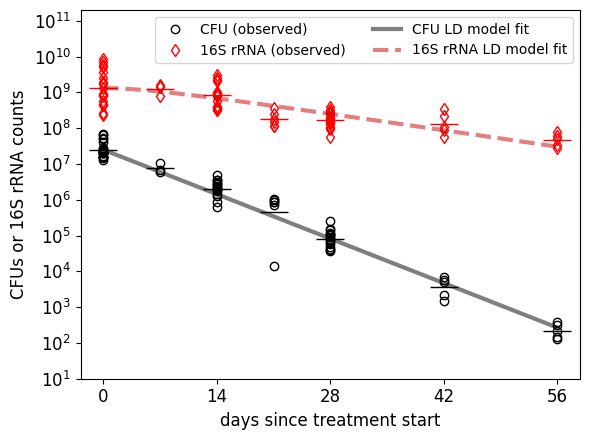

In [14]:
#This cell plots in vivo data for HRZE treatment of mice, including best fit of LD model
#Simulate system with optimized delta and deltaS
modelPredictions = ddDynamics( delta, deltaS, b0sim, 0, 0, 56, nt=10*56+1 )

#get CFU (bsim) an 16S rRNA counts (ssim) from simulation
n0 = r16sav[0]/b0sim
tsim = modelPredictions["t"]
bsim = modelPredictions["y"][0]
dsim = modelPredictions["y"][1]
ssim = n0 * (bsim + dsim)

#define color for 16S rRNA model fit
darkness = 0.2
lightness = 1 - darkness
transparency = 0.5
darkpink = (1*lightness,0,0)
#label size for plot
fontsize=12
fig,ax = plt.subplots(figsize=(6,4.5))
#plot cfu data
ax.plot(days,cfus,linestyle='none',marker='o',markerfacecolor='none',color = 'black',label="CFU (observed)")
#plot 16S rRNA data
ax.plot(days,r16s,linestyle='none',marker='d',markerfacecolor='none',color = 'red',label="16S rRNA (observed)")
#plot average CFU
ax.plot(daysunique,cfusav,linestyle='none',marker='_',markerfacecolor='none',color='black',markersize=20)
#plot average 16S rRNA counts
ax.plot(daysunique,r16sav,linestyle='none',marker='_',markerfacecolor='none',color='red',markersize=20)
#plot model fits
ax.plot(tsim,bsim,color='black',alpha=1-transparency,linewidth=3,label="CFU LD model fit")
ax.plot(tsim,ssim,color=darkpink,alpha=1-transparency,linewidth=3,linestyle='dashed',label="16S rRNA LD model fit")
#set up axes: log scale, labels, ticks
ax.set_yscale('log')
ax.set_xlabel('days since treatment start',fontsize=fontsize)
ax.set_ylabel('CFUs or 16S rRNA counts',fontsize=fontsize)
ax.set_xticks([0,14,28,42,56])
ax.set_yticks([pow(10,1),pow(10,2),pow(10,3),pow(10,4),pow(10,5),pow(10,6),pow(10,7),pow(10,8),pow(10,9),pow(10,10),pow(10,11)])
ax.set_ylim([10,pow(10,11.3)])
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
#legend -- two columns to fit on top
plt.legend(ncols=2,loc='upper right')
#layout
plt.tight_layout()
plt.savefig('supplementFigureInVivoHRZEpanelA.pdf',format='pdf')


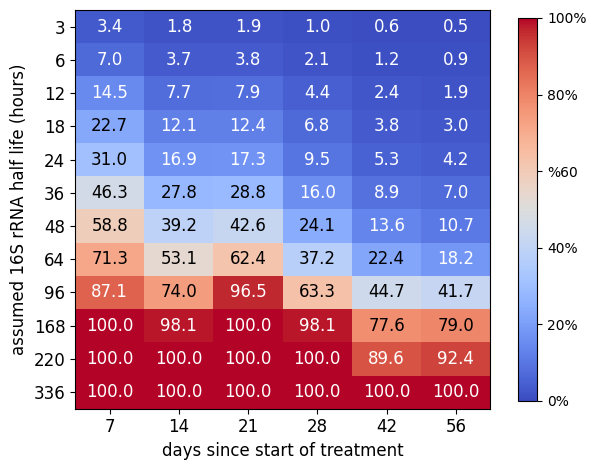

In [15]:
#This cell generates the heatmap table showing fraction of the gap explained by the 
#LD model, for different assumed decay rates of residual 16S rRNA

ppd  = 10 #points per day
def index( t ):
    #returns the index in simulation results of populations at time t
    return t * ppd

#List of half lifes for simulations
halfLifeList = np.array([3,6,12,18,24,36,48,64,96,168,220,336]) #in hours
halfLifeListDays = halfLifeList/24 #list of half lifes to simulate, in days
for i in range( halfLifeListDays.size ):
    if (halfLifeListDays[i] == 0):
        halfLifeListDays[i] = 0.001 #short half life limit - not used in paper - the predicted gap will be zero.
deltaSlist = np.log(2)/halfLifeListDays #list of decay rates to simulate
ppd = 10 #points per day - simulation parameter that primarily matters for visualization
#initialize list to hold results
tableGapLog = []
for deltaS in deltaSlist:
    #integrate model
    modelPredictions = ddDynamics( delta, deltaS, b0sim, 0, 0, 56, nt=ppd*56+1 )
    #collect simulation results
    n0 = r16sav[0]/b0sim
    tsim = modelPredictions["t"]
    bsim = modelPredictions["y"][0]
    dsim = modelPredictions["y"][1]
    ssim = n0 * (bsim + dsim)
    #calculate gap
    modelGap = ssim/bsim #proportionate gap
    modelGap = modelGap / modelGap[0] #proportionate gap starts at 1.
    modelGapLog = np.log10( modelGap ) #logarithmic gap (starts at 0)
    deltaSgapLog = [] #array to hold the portion of the (logarithmic) gap explainable by decay at rate deltaS
    #calculate fraction of gap explained by the model
    for d in range( len( daysunique ) ):
        if( d > 0 ):
            if (cfusav[d] < 0.5):
                #When CFU are not detected, the observed gap is not well defined. Accordingly, substitute 
                #The model predicted CFU (i.e., bsim[index(daysunique[d])]).
                #Note this does not actually effect the in vivo data analysis, but is left here for simplicity
                #of reusing code.
                logGapData[d] = log10((r16sav[d]/bsim[index(daysunique[d])])/(r16sav[0]/cfusav[0]))
            if (logGapData[d] == 0):
                #When the gap is zero, the fraction of the gap is not well defined. This is only relevant at time 
                #of treatment start, which we omit from our final analysis.
                deltaSgapLog.append( 100 )
            else:
                #If observed gap is not zero, simply calculate the percent of the 
                #gap explained as 100% x model gap/observed gap
                deltaSgapLog.append( 100 * modelGapLog[index(daysunique[d])]/logGapData[d] )
    tableGapLog.append( deltaSgapLog )

#Cap values at 100% (You can optionally comment this loop, if interested 
#in the extent to which the model gap exceeds 100% of the observed gap.)
for i in range( len(tableGapLog) ):
    for j in range( len(tableGapLog[0]) ):
        if (tableGapLog[i][j] > 100):
            tableGapLog[i][j] = 100


#shrink factor for the figure
shrink = 0.96
#fontsize for the figure
fontsize=12
fig,ax=plt.subplots()
#set up axes
ax.set_xticks( np.arange(len(daysunique) - 1 ), daysunique[1:], fontsize=fontsize )
ax.set_yticks( np.arange(len(halfLifeList)), halfLifeList, fontsize=fontsize )
#generate heatmap
heatmap = ax.imshow(tableGapLog,aspect=0.48,cmap='coolwarm', vmin=0, vmax = 100)
#add labels
for i in range( len(halfLifeList) ):
    for j in range( len( daysunique ) - 1 ):
        #number to write in the grid
        number = tableGapLog[i][j]
        #switch font color between dark and light cells, for readability
        if (abs(number-50) < 30):
            color = "black"
        else:
            color = "w"
        #add the label
        ax.text(j, i, f"{number:.1f}", ha="center", va="center", color=color, fontsize=fontsize)
#label axes
ax.set_ylabel( "assumed 16S rRNA half life (hours)", fontsize=fontsize )
ax.set_xlabel( "days since start of treatment", fontsize=fontsize )
#add colorbar
cbar=plt.colorbar(heatmap, shrink = shrink,ticks=[0,20,40,60,80,100])
#label colorbar
cbar.ax.set_yticklabels(["0%","20%","40%","%60","80%","100%"])
#adjust layout
plt.tight_layout()
#save figure
plt.savefig('supplementFigureInVivoHRZEpanelB.pdf',format='pdf')
